#框架

In [17]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. 
        
        and the value is *ax + b*
        """
        self.inputs = inputs # input_list <- C, Java <- 匈牙利命名法 -> Python 特别不建议
       # self.outputs = outputs # output_list 
        self.value = None 
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:#inputs2个点，list[A,B],A的输出加上B的输出
            node.outputs.append(self) # build a connection relationship
    
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value 
        into *self.value*
        """
        raise NotImplemented #虚类，要求其子类一定要实现，不实现的时候会导致问题
    
    def backward(self):
        """ Back propogation
        
        compute the gradient of each input node and store the value 
        into "self.gredients"
        """
        raise NotImplemented

In [18]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name= name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
#     def __repr__(self):
#         return 'Input Node: {}'.format(self.name)

In [19]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self): 
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value#np.dot(X, W) + B
        
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [20]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
    
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.x_node] = grad_cost * self.partial

In [21]:
class MSE(Node):#loss
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
    
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] =  (-2 / n) * self.diff

In [22]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [23]:
def topological_sort(data_with_value):
    feed_dict = data_with_value 
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [24]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

数据

In [76]:
from sklearn.datasets import load_boston
import numpy as np
data = load_boston()

In [77]:
X_ = data['data']
y_ = data['target']

In [78]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)#axis=0列，np.std标准差

In [79]:
X_.shape

(506, 13)

In [80]:
n_features = X_.shape[1]#特征数
n_hidden = 10
# n_hidden_2 = 10

In [81]:
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)#标准正态分布
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)
# W2_, b2_ = np.random.randn(n_hidden, n_hidden_2), np.zeros(n_hidden_2)
# W3_, b3_ = np.random.randn(n_hidden_2, 1), np.zeros(1)

In [82]:
W2_

array([[ 0.28510275],
       [ 0.3849249 ],
       [-0.2894206 ],
       [ 1.00699906],
       [ 0.12492095],
       [ 0.73470094],
       [ 0.26775248],
       [ 0.17709125],
       [-0.44695528],
       [-1.33587122]])

In [83]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
# W3, b3 = Input(name='W3'), Input(name='b3')

In [84]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
# linear_output_2 = Linear(sigmoid_output, W2, b2)
# sigmoid_output_2 = Sigmoid(linear_output_2)
# yhat = Linear(sigmoid_output_2, W3, b3)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

In [85]:
input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_,
#     W3: W3_, 
    b1: b1_, 
    b2: b2_,
#     b3: b3_ 
}

In [86]:
graph = topological_sort(input_node_with_value)

In [87]:
graph

In [88]:
from sklearn.utils import resample

In [89]:
# np.random.choice(range(100), size=10, replace=True)

In [90]:
# def run(dictionary):
#     return topological_sort(dictionary)

In [92]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size


for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
#         input_node_with_value = {  # -> feed_dict 
#             X: X_batch, 
#             y: y_batch, 
#             W1: W1.value, 
#             W2: W2.value, 
#             b1: b1.value, 
#             b2: b2.value,
#         }
        
#         graph = topological_sort(input_node_with_value)
        
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
#         sgd_update(trainable_nodes=[W1, W2, b1, b2,W3,b3], learning_rate=learning_rate)
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 568.935
Epoch: 101, loss = 29.804
Epoch: 201, loss = 24.299
Epoch: 301, loss = 20.325
Epoch: 401, loss = 13.945
Epoch: 501, loss = 16.803
Epoch: 601, loss = 16.946
Epoch: 701, loss = 12.748
Epoch: 801, loss = 11.247
Epoch: 901, loss = 10.763
Epoch: 1001, loss = 13.298
Epoch: 1101, loss = 8.208
Epoch: 1201, loss = 9.997
Epoch: 1301, loss = 8.152
Epoch: 1401, loss = 11.153
Epoch: 1501, loss = 8.960
Epoch: 1601, loss = 8.964
Epoch: 1701, loss = 8.775
Epoch: 1801, loss = 10.090
Epoch: 1901, loss = 7.059
Epoch: 2001, loss = 8.255
Epoch: 2101, loss = 7.677
Epoch: 2201, loss = 7.822
Epoch: 2301, loss = 7.896
Epoch: 2401, loss = 7.610
Epoch: 2501, loss = 8.279
Epoch: 2601, loss = 8.474
Epoch: 2701, loss = 8.425
Epoch: 2801, loss = 8.306
Epoch: 2901, loss = 6.564
Epoch: 3001, loss = 6.636
Epoch: 3101, loss = 7.565
Epoch: 3201, loss = 5.592
Epoch: 3301, loss = 6.556
Epoch: 3401, loss = 7.951
Epoch: 3501, loss = 9.145
Epoch: 3601, loss = 6.019
Epoch: 3701, loss = 6.614
Epoch: 380

In [93]:
import matplotlib.pyplot as plt

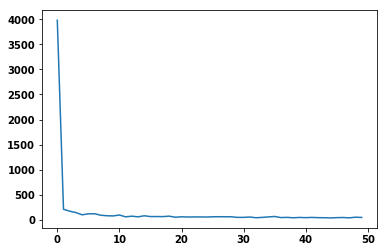

In [94]:
plt.plot(losses)

# “⾖豆瓣评论” classiﬁcation

In [1]:
import numpy as np
import pandas as pd
content = pd.read_csv('./movie_comments.csv')#读取文件
content.head(10)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1
5,6,https://movie.douban.com/subject/26363254/,战狼2,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,7,https://movie.douban.com/subject/26363254/,战狼2,脑子是个好东西，希望编剧们都能有。,2
7,8,https://movie.douban.com/subject/26363254/,战狼2,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,9,https://movie.douban.com/subject/26363254/,战狼2,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,10,https://movie.douban.com/subject/26363254/,战狼2,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


In [2]:
# content_null = content.isnull().sum()#产看缺失值
# content = content.dropna()#除去缺失值
# content_all = content.reset_index(drop=True)#重建索引

In [3]:
len(content)

261497

In [4]:
# print (content_all.isnull().sum())

# 数据预处理

In [5]:
import jieba
import re 
def cut(string):
    return ' '.join(jieba.cut(re.sub(r'[^\w\s]',' ',string.strip())))

In [6]:
content['content_cut'] = content["comment"].fillna('').apply(cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\MSI\AppData\Local\Temp\jieba.cache
Loading model cost 1.365 seconds.
Prefix dict has been built succesfully.


In [7]:
content.head(10)

,id,link,name,comment,star,content_cut
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1,吴京 意淫 到 了 脑残 的 地步 看 了 恶心 想 吐
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2,首映礼 看 的 太 恐怖 了 这个 电影 不讲道理 的 完全 就是 吴京 在 实...
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2,吴京 的 炒作 水平 不输 冯小刚 但小刚 至少 不会 用 主旋律 来 炒作 吴京 ...
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4,凭良心说 好 看到 不像 战狼 1 的 续集 完虐 湄公河 行动
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1,中二得 很
5,6,https://movie.douban.com/subject/26363254/,战狼2,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1,犯 我 中华 者 虽远必 诛 吴京 比 这句 话 还要 意淫 一百倍
6,7,https://movie.douban.com/subject/26363254/,战狼2,脑子是个好东西，希望编剧们都能有。,2,脑子 是 个 好 东西 希望 编剧 们 都 能 有
7,8,https://movie.douban.com/subject/26363254/,战狼2,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4,三星 半 实打实 的 7 分 第一集 在 爱国 主旋律 内部 做 着 各种 置换 与...
8,9,https://movie.douban.com/subject/26363254/,战狼2,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4,开篇 长镜头 惊险 大气 引人入胜 结合 了 水平 不俗 的 快 剪下 实打实 的 真刀...
9,10,https://movie.douban.com/subject/26363254/,战狼2,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1,15 100 吴京 的 冷峰 在 这部 里 即 像 成龙 又 像杰 森斯坦 森 ...


In [8]:
content.iloc[560:570]

,id,link,name,comment,star,content_cut
560,33,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,2013.04.25 掉渣天的画质,5,2013 04 25 掉 渣 天 的 画质
561,34,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,只有凌波，我一定要救出来！新加：上映当天就被剧透到死了，今天枪版观看完毕，说不上来的感觉，是...,5,只有 凌波 我 一定 要 救 出来 新加 上映 当天 就 被 剧透到 死 了 ...
562,35,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,距离发动失败的第三次冲击已经14年的时间，整个世界已经不一样，碇真嗣再一次被导向发动第四次冲...,4,距离 发动 失败 的 第三次 冲击 已经 14 年 的 时间 整个 世界 已经 不 一样...
563,36,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,这到底神马情况，各种乱入..........,3,这 到底 神马 情况 各种 乱入
564,37,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,多么中二的剧情，就是一群小青年想玩文艺，来着全人类做铺垫的故事，三星完全是给作画的，剧情就是一坨屎,3,多么 中二 的 剧情 就是 一群 小青年 想 玩 文艺 来 着 全人类 做 铺垫 的...
565,38,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,疯了,5,疯 了
566,39,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,gay死它得了。碇真治对㶆薰那一脸的菊花湿润瘙痒啊。。。,3,gay 死 它 得 了 碇真治 对 㶆 薰 那 一脸 的 菊花 湿润 瘙痒 啊
567,40,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,等我明白了再决定是不是加一星= =,4,等 我 明白 了 再 决定 是不是 加一星
568,id,link,name,comment,star,comment
569,1,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,盼了两年，火急火燎全神贯注地看完后……吭爹啊！除了基佬薰必须成一坨血的结局外，这货跟老版TV...,5,盼 了 两年 火急火燎 全神贯注 地看 完后 吭爹 啊 除了 基佬 薰 必须...


In [9]:
content = content[~content['star'].isin(["star"])]#~取反

In [10]:
content.iloc[560:570]

,id,link,name,comment,star,content_cut
560,33,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,2013.04.25 掉渣天的画质,5,2013 04 25 掉 渣 天 的 画质
561,34,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,只有凌波，我一定要救出来！新加：上映当天就被剧透到死了，今天枪版观看完毕，说不上来的感觉，是...,5,只有 凌波 我 一定 要 救 出来 新加 上映 当天 就 被 剧透到 死 了 ...
562,35,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,距离发动失败的第三次冲击已经14年的时间，整个世界已经不一样，碇真嗣再一次被导向发动第四次冲...,4,距离 发动 失败 的 第三次 冲击 已经 14 年 的 时间 整个 世界 已经 不 一样...
563,36,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,这到底神马情况，各种乱入..........,3,这 到底 神马 情况 各种 乱入
564,37,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,多么中二的剧情，就是一群小青年想玩文艺，来着全人类做铺垫的故事，三星完全是给作画的，剧情就是一坨屎,3,多么 中二 的 剧情 就是 一群 小青年 想 玩 文艺 来 着 全人类 做 铺垫 的...
565,38,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,疯了,5,疯 了
566,39,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,gay死它得了。碇真治对㶆薰那一脸的菊花湿润瘙痒啊。。。,3,gay 死 它 得 了 碇真治 对 㶆 薰 那 一脸 的 菊花 湿润 瘙痒 啊
567,40,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,等我明白了再决定是不是加一星= =,4,等 我 明白 了 再 决定 是不是 加一星
569,1,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,盼了两年，火急火燎全神贯注地看完后……吭爹啊！除了基佬薰必须成一坨血的结局外，这货跟老版TV...,5,盼 了 两年 火急火燎 全神贯注 地看 完后 吭爹 啊 除了 基佬 薰 必须...
570,2,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,时隔那么多年，明日香又登女神榜，薰继续是大爱！可惜，我依旧讨厌圣母小白什么的！,4,时隔 那么 多年 明日香 又 登 女神 榜 薰 继续 是 大爱 可惜 我 依...


In [11]:
content.iloc[568]

id                                                             1
link                   https://movie.douban.com/subject/2567647/
name                                   福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q
comment        盼了两年，火急火燎全神贯注地看完后……吭爹啊！除了基佬薰必须成一坨血的结局外，这货跟老版TV...
star                                                           5
content_cut    盼 了 两年   火急火燎 全神贯注 地看 完后     吭爹 啊   除了 基佬 薰 必须...
Name: 569, dtype: object

In [12]:
len(content)

261496

In [13]:
# cols=[x for i,x,in enumerate(content.columns) if content.iat[4,i]== "null"]#content.columns列

In [14]:
# content_null = content.isnull().sum()#产看缺失值
content_all = content.dropna()#除去缺失值
content_all = content_all.reset_index(drop=True)#重建索引

In [15]:
content.iloc[560:570]

,id,link,name,comment,star,content_cut
560,33,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,2013.04.25 掉渣天的画质,5,2013 04 25 掉 渣 天 的 画质
561,34,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,只有凌波，我一定要救出来！新加：上映当天就被剧透到死了，今天枪版观看完毕，说不上来的感觉，是...,5,只有 凌波 我 一定 要 救 出来 新加 上映 当天 就 被 剧透到 死 了 ...
562,35,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,距离发动失败的第三次冲击已经14年的时间，整个世界已经不一样，碇真嗣再一次被导向发动第四次冲...,4,距离 发动 失败 的 第三次 冲击 已经 14 年 的 时间 整个 世界 已经 不 一样...
563,36,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,这到底神马情况，各种乱入..........,3,这 到底 神马 情况 各种 乱入
564,37,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,多么中二的剧情，就是一群小青年想玩文艺，来着全人类做铺垫的故事，三星完全是给作画的，剧情就是一坨屎,3,多么 中二 的 剧情 就是 一群 小青年 想 玩 文艺 来 着 全人类 做 铺垫 的...
565,38,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,疯了,5,疯 了
566,39,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,gay死它得了。碇真治对㶆薰那一脸的菊花湿润瘙痒啊。。。,3,gay 死 它 得 了 碇真治 对 㶆 薰 那 一脸 的 菊花 湿润 瘙痒 啊
567,40,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,等我明白了再决定是不是加一星= =,4,等 我 明白 了 再 决定 是不是 加一星
569,1,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,盼了两年，火急火燎全神贯注地看完后……吭爹啊！除了基佬薰必须成一坨血的结局外，这货跟老版TV...,5,盼 了 两年 火急火燎 全神贯注 地看 完后 吭爹 啊 除了 基佬 薰 必须...
570,2,https://movie.douban.com/subject/2567647/,福音战士新剧场版：Q ヱヴァンゲリヲン新劇場版：Q,时隔那么多年，明日香又登女神榜，薰继续是大爱！可惜，我依旧讨厌圣母小白什么的！,4,时隔 那么 多年 明日香 又 登 女神 榜 薰 继续 是 大爱 可惜 我 依...


In [16]:
len(content_all)

261494

In [17]:
content_all.iloc[55].content_cut

'燃   大 场面 真的 不输 国外 大片 不 尴尬   吴京 打戏 很 精彩   水下 搏斗 看着 也 很 有力   必须 安利 一下张 翰   这 角色 简直 就是 个 彩蛋 啊   承包 所有 笑点   为 他 量身定做 的 哈哈哈   彭于 晏 可演 不来   是 真的 好看'

#建立训练模型

In [19]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import os
import multiprocessing

D:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [20]:
def embedding_sentences(sentences, embedding_size = 128, window = 5, min_count = 5, file_to_load = None, file_to_save = None):
    if file_to_load is not None:
        w2vModel = Word2Vec.load(file_to_load)
    else:
        w2vModel = Word2Vec(sentences, size = embedding_size, window = window, min_count = min_count, workers = multiprocessing.cpu_count())
        if file_to_save is not None:
            w2vModel.save(file_to_save)
    all_vectors = []
    embeddingDim = w2vModel.vector_size
    embeddingUnknown = [0 for i in range(embeddingDim)]
    for sentence in sentences:
        this_vector = []
        for word in sentence:
            if word in w2vModel.wv.vocab:
                this_vector.append(w2vModel[word])
            else:
                this_vector.append(embeddingUnknown)
        all_vectors.append(this_vector)
    return all_vectors

In [21]:
def padding_sentences(input_sentences, padding_token, padding_sentence_length = None):
    sentences = [sentence.split(' ') for sentence in input_sentences]
    max_sentence_length = padding_sentence_length if padding_sentence_length is not None else max([len(sentence) for sentence in sentences])
    for sentence in sentences:
        if len(sentence) > max_sentence_length:
            sentence = sentence[:max_sentence_length]
        else:
            sentence.extend([padding_token] * (max_sentence_length - len(sentence)))
    return (sentences, max_sentence_length)

In [22]:
sentences_content, max_document_length_content = padding_sentences(list(content_all.content_cut[:10000]), '<PADDING>')

In [23]:
len(list(content_all.content_cut))

261494

In [24]:
len(sentences_content)

10000

In [30]:
x = np.array(embedding_sentences(sentences_content, embedding_size = 128, file_to_save = os.path.join("./", 'trained_word2vec.model')),dtype=float)

D:\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [31]:
x.shape

(10000, 195, 128)

In [33]:
y = np.array(content_all.star[:10000].values,dtype=int)

In [34]:
y[0:50]

array([1, 2, 2, 4, 1, 1, 2, 4, 4, 1, 1, 4, 1, 2, 2, 5, 2, 3, 3, 2, 4, 4,
       4, 1, 4, 2, 2, 4, 1, 4, 3, 4, 5, 1, 3, 1, 4, 2, 2, 2, 1, 3, 5, 3,
       4, 3, 3, 5, 2, 1])

In [35]:
# import tensorflow as tf
# one_hot=tf.one_hot(y,5)
 
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     y_one = sess.run(one_hot)

In [85]:
#one_hot
def reformat(labels):
#   Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(5) == labels[:,None]).astype(np.float32)
  return labels

In [86]:
y_one = reformat(y)

In [87]:
y_one[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [38]:
from sklearn.model_selection import train_test_split#直接用交叉验证?
X_train, X_test, y_train, y_test = train_test_split(x, y_one, test_size=0.3, random_state=42)

In [39]:
print(X_train.shape)
print(X_test.shape)

(7000, 195, 128)
(3000, 195, 128)


# gensim,one_hot转词向量，3中[2,3,4]词数量组合

构建连接model

In [40]:
sequence_length=x.shape[1]
num_classes=y_one.shape[1]
embedding_size=128
filter_sizes=[2,3,4]
num_filters= 64
l2_reg_lambda=0.0

In [41]:
input_x = tf.placeholder(tf.float32, [None,sequence_length, embedding_size], name = "input_x")
input_y = tf.placeholder(tf.float32, [None, num_classes], name = "input_y")
dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")

# Keeping track of l2 regularization loss (optional)
l2_loss = tf.constant(0.0)

# Embedding layer
    # self.embedded_chars = [None(batch_size), sequence_size, embedding_size]
    # self.embedded_chars = [None(batch_size), sequence_size, embedding_size, 1(num_channels)]
embedded_chars = input_x
embedded_chars_expended = tf.expand_dims(embedded_chars, -1)
print("a{}".format(embedded_chars_expended.shape))#x_image = tf.reshape(x_, [-1,195,128,1])

a(?, 195, 128, 1)


In [42]:
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):

    with tf.name_scope("conv-maxpool-%s" % filter_size):
   # Convolution layer
        filter_shape = [filter_size, embedding_size, 1, num_filters]#h（几个单词）,w[128],1维（如果有多个维度，就多维度数据相加），128（想要128个特征，也就是filters层数）[2,128,1,128]
        W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")#
        b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
        conv = tf.nn.conv2d(embedded_chars_expended,
                    W,
                    strides=[1,1,1,1],
                    padding="VALID",
                   name="conv")
# Apply nonlinearity
        h = tf.nn.relu(tf.nn.bias_add(conv, b), name = "relu")#b是一维
# Maxpooling over the outputs
        pooled = tf.nn.max_pool(
                                h,
                                ksize=[1, sequence_length - filter_size + 1, 1, 1],#
                                strides=[1,1,1,1],
                                padding="VALID",
                                name="pool")
        pooled_outputs.append(pooled)

Instructions for updating:
Colocations handled automatically by placer.


In [43]:
pooled_outputs

[<tf.Tensor 'conv-maxpool-2/pool:0' shape=(?, 1, 1, 64) dtype=float32>,
 <tf.Tensor 'conv-maxpool-3/pool:0' shape=(?, 1, 1, 64) dtype=float32>,
 <tf.Tensor 'conv-maxpool-4/pool:0' shape=(?, 1, 1, 64) dtype=float32>]

In [44]:
# Combine all the pooled features
num_filters_total = num_filters * len(filter_sizes)
h_pool = tf.concat(pooled_outputs,3)
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])#3个向量叠加起来
# Add dropout
with tf.name_scope("dropout"):
    h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [45]:
h_drop

<tf.Tensor 'dropout/dropout/mul:0' shape=(?, 192) dtype=float32>

In [46]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1) # 取随机值，符合均值为0，标准差stddev为0.1
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [47]:
# Final (unnomalized) scores and predictions

with tf.name_scope("output"):
#     tf.reset_default_graph()
    W_f = weight_variable([64*3*1, 5])
#     W_f = tf.Variable("W_f2",shape = [64*3*1, 5],initializer = tf.contrib.layers.xavier_initializer())
#     b_f = tf.Variable(tf.constant(0.1, shape=[num_classes], name = "b"))
    b_f = bias_variable([num_classes])
    l2_loss += tf.nn.l2_loss(W_f)
    l2_loss += tf.nn.l2_loss(b_f)
    scores = tf.nn.xw_plus_b(h_drop, W_f, b_f, name = "scores")
    predictions = tf.argmax(scores, 1, name = "predictions")

# Calculate Mean cross-entropy loss
with tf.name_scope("loss"):
    losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits = scores, labels = input_y)
    loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

# Accuracy
with tf.name_scope("accuracy"):
    correct_predictions = tf.equal(predictions, tf.argmax(input_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name = "accuracy")
# correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1)) 
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

#run

In [48]:
# 为训练过程指定最小化误差用的损失函数，即目标类别和预测类别之间的交叉熵
cross_entropy = -tf.reduce_sum(input_y*tf.log(loss))

# 使用反向传播，利用优化器使损失函数最小化
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)#GradientDescentOptimizer(0.5) #梯度下降,0.5学习率

In [50]:
saver = tf.train.Saver() # 定义saver
batch_size = 100
# *************** 开始训练模型 *************** #
# one_hot=tf.one_hot(y,5)
 
with tf.Session().as_default() as sess2:
    sess2.run(tf.global_variables_initializer())
#     y_one = sess.run(one_hot)
    for i in range(1000):
        offset = (i * batch_size) % (X_train.shape[0] - batch_size)#这句是防止迭代次数过多超出数据集范围，就通过取余数改变取batch的偏置
        batch_data = X_train[offset:(offset + batch_size), :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
#         print(batch_data.shape)
#         print(batch_labels.shape)
        if i%100 == 0:
        # 评估模型准确度，此阶段不使用Dropout
            train_accuracy = accuracy.eval(feed_dict={input_x:batch_data, input_y:batch_labels, dropout_keep_prob: 1.0})#概率是1，也就是说 在测试时保留所有连接
            
            print("step %d, training accuracy %g"%(i, train_accuracy))

      # 训练模型，此阶段使用50%的Dropout
        train_step.run(feed_dict={input_x: batch_data, input_y: batch_labels, dropout_keep_prob: 0.5}) 

    saver.save(sess2, './save1/model.ckpt') #模型储存位置

    print("test accuracy %g"%accuracy.eval(feed_dict={input_x: X_test,input_y: y_test, dropout_keep_prob: 1.0}))


step 0, training accuracy 0.23
step 100, training accuracy 0.22
step 200, training accuracy 0.29
step 300, training accuracy 0.21
step 400, training accuracy 0.29
step 500, training accuracy 0.26
step 600, training accuracy 0.26
step 700, training accuracy 0.31
step 800, training accuracy 0.27
step 900, training accuracy 0.27
test accuracy 0.266333


# 网上代码

In [51]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    '''
    Generate a batch iterator for a dataset
    '''
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((data_size - 1) / batch_size) + 1
    for epoch in range(num_epochs):
        if shuffle:
        # Shuffle the data at each epoch
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
    for batch_num in range(num_batches_per_epoch):
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, data_size)
        yield shuffled_data[start_idx : end_idx]

In [68]:
class TextCNN(object):
    '''
    A CNN for text classification
    Uses and embedding layer, followed by a convolutional, max-pooling and softmax layer.
    '''
    def __init__(
        self, sequence_length, num_classes,
        embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output, dropout
        self.input_x = tf.placeholder(tf.float32, [None, sequence_length, embedding_size], name = "input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name = "input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
        
        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
            # self.embedded_chars = [None(batch_size), sequence_size, embedding_size]
            # self.embedded_chars = [None(batch_size), sequence_size, embedding_size, 1(num_channels)]
        self.embedded_chars = self.input_x
        self.embedded_chars_expended = tf.expand_dims(self.embedded_chars, -1)
        print("a{}".format(self.embedded_chars_expended.shape))
        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]#h（几个单词）,w,1维，128（想要128个特征）
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expended,
                                    W,
                                    strides=[1,1,1,1],
                                    padding="VALID",
                            name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name = "relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                h,
                ksize=[1, sequence_length - filter_size + 1, 1, 1],#
                strides=[1,1,1,1],
                padding="VALID",
                name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs,3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)
        
        # Final (unnomalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                                "W",
                                    shape = [num_filters_total, num_classes],
                                    initializer = tf.contrib.layers.xavier_initializer())
            
            b = tf.Variable(tf.constant(0.1, shape=[num_classes], name = "b"))
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name = "scores")
            self.predictions = tf.argmax(self.scores, 1, name = "predictions")

        # Calculate Mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.scores, labels = self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss
        
        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name = "accuracy")

In [75]:
def train(x_train, y_train,  x_dev, y_dev):

    # Training

    # ==================================================



    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
        allow_soft_placement = True,
        log_device_placement = False)
        sess = tf.Session(config = session_conf)
        with sess.as_default():
            cnn = TextCNN(
            sequence_length = x_train.shape[1],
            num_classes = y_train.shape[1],
            embedding_size = 128,
            filter_sizes = [2,3,4],
            num_filters = 64,
            l2_reg_lambda = 0.0)

        # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)#计算梯度
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)##处理梯度

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=5)

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 0.5
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = batch_iter(
            list(zip(x_train, y_train)), 64, 200)

        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % 100 == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % 100 == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

In [76]:
train(X_train, y_train, X_test, y_test)

a(?, 195, 128, 1)
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxp

2019-09-22T08:01:38.263012: step 100, loss 1.90455, acc 0.317

Saved model checkpoint to E:\新桌面\Mlearning\AI上课\上课10\作业10\runs\1569108255\checkpoints\model-100

2019-09-22T08:01:39.556647: step 101, loss 3.06685, acc 0.234375
2019-09-22T08:01:39.858532: step 102, loss 2.84295, acc 0.25
2019-09-22T08:01:40.026434: step 103, loss 4.68455, acc 0.234375
2019-09-22T08:01:40.190147: step 104, loss 4.09302, acc 0.265625
2019-09-22T08:01:40.349505: step 105, loss 4.29363, acc 0.265625
2019-09-22T08:01:40.501453: step 106, loss 4.36346, acc 0.28125
2019-09-22T08:01:40.653675: step 107, loss 3.79608, acc 0.1875
2019-09-22T08:01:40.812599: step 108, loss 5.16009, acc 0.171875
2019-09-22T08:01:40.968929: step 109, loss 3.4882, acc 0.203125
2019-09-22T08:01:41.049143: step 110, loss 4.31981, acc 0.25


# 神经网络，TFIDF转词向量，全连接，效果不好

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
# token_pattern这个参数使用正则表达式来分词，其默认参数为r"(?u)\b\w\w+\b"，其中的两个\w决定了其匹配长度至少为2的单词
# 长度为1的单词在英文中一般是无足轻重的，但在中文里，就可能有一些很重要的单字词
# 当设置为浮点数时，过滤出现在超过max_df/低于min_df比例的句子中的词语；正整数时,则是超过max_df句句子。
vectorized = TfidfVectorizer(max_features=1000, token_pattern=r"(?u)\b\w\w+\b", max_df = 1.0,
                                 stop_words = ["是", "的","了"],vocabulary = None )#

In [32]:
# vectorized = TfidfVectorizer(max_features=10000)#(max_features=10000)#TfidfVectorizer 完成向量化与 TF-IDF 预处理。

In [33]:
features = vectorized.fit_transform(content_all.content_cut).toarray()#这里转换稀疏矩阵，占用内存太大

In [34]:
features.shape

(261494, 1000)

In [35]:
features[49999]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [36]:
target = np.array(content_all.star.values,dtype=int)#转列表,定义类型

In [37]:
target[49999]

3

In [38]:
from sklearn.model_selection import train_test_split#直接用交叉验证?
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

183045
183045
78449
78449


In [39]:
X_test.shape

(78449, 1000)

In [41]:
# image_size = 28
num_labels = 5
def reformat(dataset, labels):
  dataset = dataset.reshape((-1, 1000)).astype(np.float32)
#   Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)

  return dataset, labels
train_dataset, train_labels = reformat(X_train, y_train)
# valid_dataset, valid_labels = reformat(X_test, y_test)
test_dataset, test_labels = reformat(X_test, y_test)
print('Training set', train_dataset.shape, train_labels.shape)
# print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (183045, 1000) (183045, 5)
Test set (78449, 1000) (78449, 5)


In [42]:
test_labels[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [43]:
#下一步我们先定义一个用来检测预测精度的方法：
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])#注意这里的argmax方法返回的是数组的索引值。

In [44]:
# 1层

In [59]:
import tensorflow as tf
batch_size = 32

graph = tf.Graph()
with graph.as_default():
#   tf.cast(X_test,tf.float32)
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, 1000))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 5))
#   tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
#   Variables.
  weights = tf.Variable(tf.truncated_normal([1000, 5]))
  biases = tf.Variable(tf.zeros([5]))
  #model
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  relu_layer= tf.nn.relu(logits)#relu的作用，激活函数
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=relu_layer))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)#SGD

#     optimizer = tf.train.AdamOptimizer(0.1, epsilon=1e-08).minimize(loss)#默认的learning_rate=0.001，ADAM
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
#   valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [43]:
# 2层，为什么用2层效果反而更差？

In [72]:
import tensorflow as tf
embedding_size = 1000
num_nodes= 1024
batch_size = 150

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, embedding_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
#     tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.    
    weights_1 = tf.Variable(tf.truncated_normal([embedding_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
#     relu_layer_2= tf.nn.relu(logits_2)#不rule,loss巨大？模型不对？
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits_2))


    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)#和relu_layer_2一样？
    
#     # Predictions for validation 
#     logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
#     relu_layer= tf.nn.relu(logits_1)
#     logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
#     valid_prediction = tf.nn.softmax(logits_2)
    
#     # Predictions for test
#     logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
#     relu_layer= tf.nn.relu(logits_1)
#     logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
#     test_prediction = tf.nn.softmax(logits_2)

In [73]:
num_steps = 5000#随机 抽取steps次，（一直训练）

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
#   init = tf.global_variables_initializer()
#   session.run(init)
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
#       print("Minibatch loss at step {}: {}".format(step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
#       print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
#   print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 11.345606
Minibatch accuracy: 26.0%
Minibatch loss at step 500: 98555854848.000000
Minibatch accuracy: 24.7%
Minibatch loss at step 1000: 378216835490573713408.000000
Minibatch accuracy: 16.0%
Minibatch loss at step 1500: 6821544067122667698026629300224.000000
Minibatch accuracy: 36.0%
Minibatch loss at step 2000: nan
Minibatch accuracy: 29.3%
Minibatch loss at step 2500: nan
Minibatch accuracy: 24.0%
Minibatch loss at step 3000: nan
Minibatch accuracy: 21.3%
Minibatch loss at step 3500: nan
Minibatch accuracy: 22.0%
Minibatch loss at step 4000: nan
Minibatch accuracy: 25.3%
Minibatch loss at step 4500: nan
Minibatch accuracy: 21.3%
